In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# import required packages
import pydicom # pydicom is a package for working with DICOM files such as medical images, reports, and radiotherapy objects
import os # os module provides functions for interacting with the operating system
import matplotlib.pyplot as plt # matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
import numpy as np # NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
from rt_utils import RTStructBuilder # rt_utils is a package for working with DICOM RT structure sets
import re # re module provides regular expression matching operations
from sklearn.model_selection import train_test_split # sklearn.model_selection is a module for splitting arrays or matrices into random train and test subsets
import numpy as np # for working with arrays
from skimage.transform import resize # for resizing images
import copy # for copying objects
import torch 
import cv2 # for working with images
import shutil # for working with files and collections of files

# Data Inspection

In [2]:
metadata = pd.read_csv('metadata.csv') # this loads the csv file into metadata dataframe

In [96]:
metadata.head() # Show the first 5 rows of the metadata dataframe

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT1,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.05 MB,./Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-TH...,2023-05-15T21:46:06.892
1,1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT2FS,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,793.95 KB,./Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-TH...,2023-05-15T21:46:24.762
2,1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,RTstructAlignedT1toPET,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.22 MB,./Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PE...,2023-05-15T21:46:30.386
3,1.3.6.1.4.1.14519.5.2.1.5168.1900.182565104594...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,RTstructAlignedT2FStoPET,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.22 MB,./Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PE...,2023-05-15T21:46:36.435
4,1.3.6.1.4.1.14519.5.2.1.5168.1900.232182644086...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,AlignedT1toPETBOX,SIEMENS MIM Software,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,61,3.84 MB,./Soft-tissue-Sarcoma/STS_001/09-07-2000-NA-PE...,2023-05-15T21:47:36.344


In [97]:
# Data Inspection
total_images = metadata['Number of Images'].sum()
# total number of series is the number of rows in the metadata dataframe 
total_series = metadata.shape[0]

series_per_subject = metadata['Subject ID'].value_counts()
# sort in ascending order of subject ID
series_per_subject = series_per_subject.sort_index()

series_per_modality = metadata['Modality'].value_counts()
images_per_subject = metadata.groupby('Subject ID')['Number of Images'].sum()
# sort in ascending order of subject ID
images_per_subject = images_per_subject.sort_index()

images_per_modality = metadata.groupby('Modality')['Number of Images'].sum()

print('Total number of images: ', total_images)
print('Total number of series: ', total_series)
print('Number of series per subject: \n', series_per_subject)
print('Number of series per modality: \n', series_per_modality)
print('Number of images per subject: \n', images_per_subject)
print('Number of images per modality: \n', images_per_modality)

Total number of images:  38283
Total number of series:  612
Number of series per subject: 
 Subject ID
STS_001    12
STS_002    12
STS_003    12
STS_004    12
STS_005    12
STS_006    12
STS_007    12
STS_008    12
STS_009    12
STS_010    12
STS_011    12
STS_012    12
STS_013    12
STS_014    12
STS_015    12
STS_016    12
STS_017    12
STS_018    12
STS_019    12
STS_020    12
STS_021    12
STS_022    12
STS_023    12
STS_024    12
STS_025    12
STS_026    12
STS_027    12
STS_028    12
STS_029    12
STS_030    12
STS_031    12
STS_032    12
STS_033    12
STS_034    12
STS_035    12
STS_036    12
STS_037    12
STS_038    12
STS_039    12
STS_040    12
STS_041    12
STS_042    12
STS_043    12
STS_044    12
STS_045    12
STS_046    12
STS_047    12
STS_048    12
STS_049    12
STS_050    12
STS_051    12
Name: count, dtype: int64
Number of series per modality: 
 Modality
RTSTRUCT    306
MR          204
PT           51
CT           51
Name: count, dtype: int64
Number of images per subj

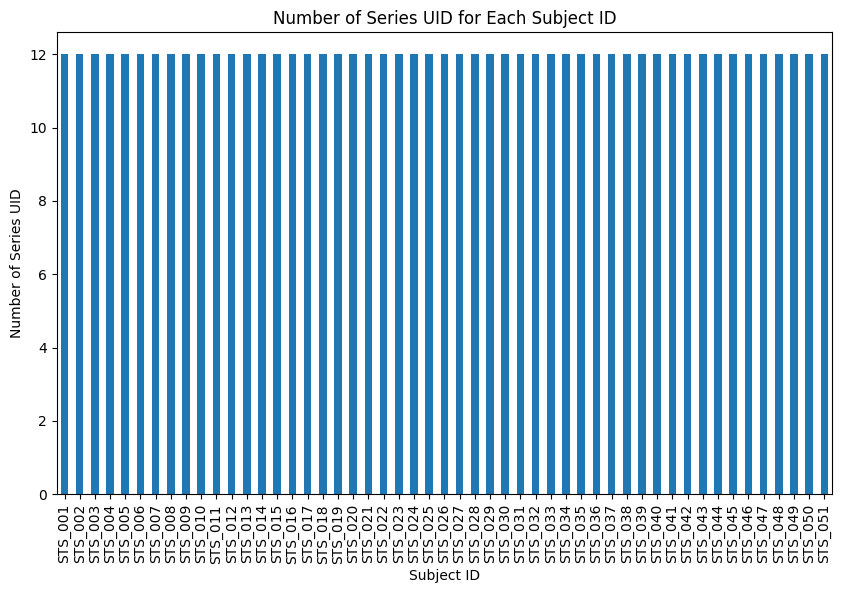

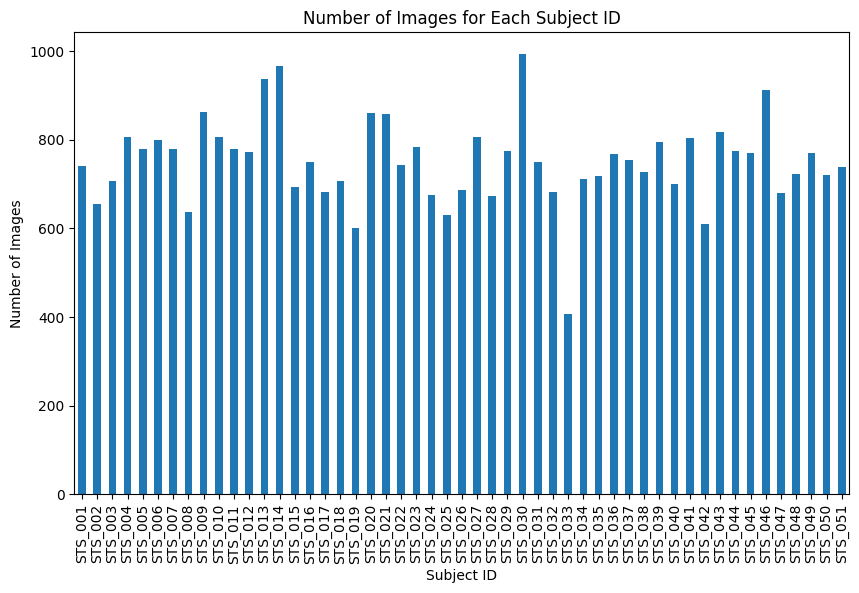

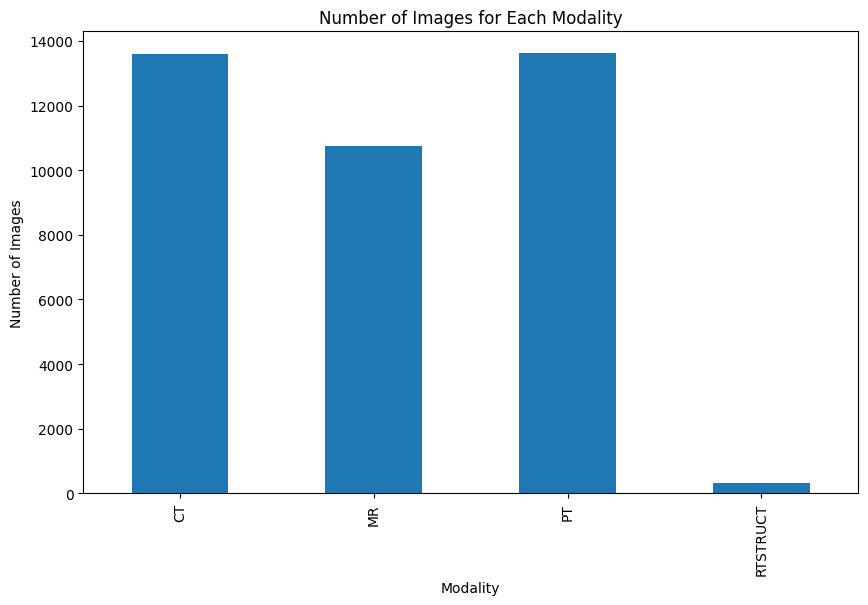

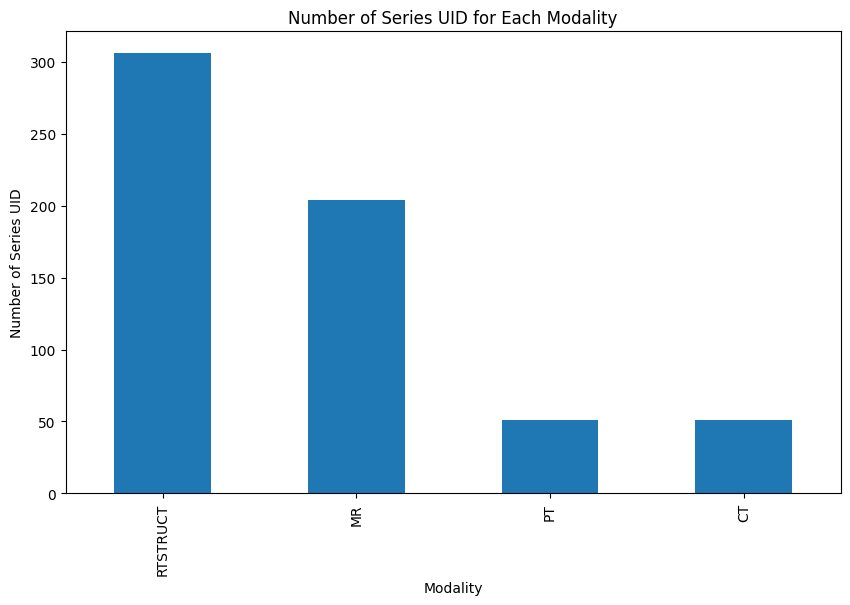

In [98]:
# Histogram of number of series UID for each subject ID
plt.figure(figsize=(10, 6))
series_per_subject.plot(kind='bar')
plt.title('Number of Series UID for Each Subject ID')
plt.xlabel('Subject ID')
plt.ylabel('Number of Series UID')
plt.show()

# Histogram of number of images for each subject ID
plt.figure(figsize=(10, 6))
images_per_subject.plot(kind='bar')
plt.title('Number of Images for Each Subject ID')
plt.xlabel('Subject ID')
plt.ylabel('Number of Images')
plt.show()

# Histogram of number of images for each modality
plt.figure(figsize=(10, 6))
images_per_modality.plot(kind='bar')
plt.title('Number of Images for Each Modality')
plt.xlabel('Modality')
plt.ylabel('Number of Images')
plt.show()

# Histogram of number of Series UID for each modality
plt.figure(figsize=(10, 6))
series_per_modality.plot(kind='bar')
plt.title('Number of Series UID for Each Modality')
plt.xlabel('Modality')
plt.ylabel('Number of Series UID')
plt.show()


# Data Processing

This cell replaces the series description with "STIR", "T1toPET", "T2FStoPET", "CT", "PET", "T1", "T2", "DAC" for easier pairing of RTStruct with its corresponding images

In [3]:
# Define a function to modify the series description
def modify_series_description(series_description):
    if "STIRtoPET" in series_description:
        return "STIRtoPET"
    elif "STIR" in series_description:
        return "STIR"
    elif "Stir" in series_description:
        return "STIR"
    elif "AX IR" in series_description:
        return "STIR"
    elif "T1toPET" in series_description:
        return "T1toPET"
    elif "T2FStoPET" in series_description:
        return "T2FStoPET"
    elif "TtoPET" in series_description:
        return "T1toPET"
    elif "PET" in series_description:
        return "PET"
    elif "T1" in series_description:
        return "T1"
    elif "T2FS" in series_description:
        return "T2FS"
    elif "T2 F" in series_description:
        return "T2FS"
    elif "FSE T2" in series_description:
        return "T2FS"
    elif "T2SP" in series_description:
        return "T2FS"
    elif "FAT T2" in series_description:
        return "T2FS"
    elif "T2" in series_description:
        return "STIR"
    elif "CT" in series_description:
        return "CT"
    elif "DAC" in series_description:
        return "PET"
    elif "Standard" in series_description:
        return "CT"
    else:
        return series_description  # If no match, return the original series description

# Apply the function to the 'Series Description' column
metadata['Series Description'] = metadata['Series Description'].apply(modify_series_description)

This cell filters the metadata dataframe into its corresponding modalities (MR, CT, PT), and also concatenates the corresponding RTstructs to it

In [4]:
# only include Series UID, Subject ID, Study UID, Series Description, Modality, and File Location of metadata
metadata_filtered = metadata[['Series UID', 'Subject ID', 'Study UID', 'Series Description', 'Modality', 'File Location']]

# Separate the dataframe based on the 'Modality' column
df_MR = metadata_filtered[metadata_filtered['Modality'] == 'MR']
df_CT = metadata_filtered[metadata_filtered['Modality'] == 'CT']
df_PT = metadata_filtered[metadata_filtered['Modality'] == 'PT']
df_RTSTRUCT = metadata_filtered[metadata_filtered['Modality'] == 'RTSTRUCT']

# Filter RTSTRUCT rows where Study UID has a match in MR, CT, and PT dataframes and a match in Series Description
rtstruct_mr = df_RTSTRUCT[df_RTSTRUCT['Study UID'].isin(df_MR['Study UID'])]
rtstruct_mr = rtstruct_mr[rtstruct_mr['Series Description'].isin(df_MR['Series Description'])]
rtstruct_ct = df_RTSTRUCT[df_RTSTRUCT['Study UID'].isin(df_CT['Study UID'])]
rtstruct_ct = rtstruct_ct[rtstruct_ct['Series Description'].isin(df_CT['Series Description'])]
rtstruct_pt = df_RTSTRUCT[df_RTSTRUCT['Study UID'].isin(df_PT['Study UID'])]
rtstruct_pt = rtstruct_pt[rtstruct_pt['Series Description'].isin(df_PT['Series Description'])]

# Append these RTSTRUCT rows to the corresponding dataframes
df_MR_rtstruct = pd.concat([df_MR, rtstruct_mr])
df_CT_rtstruct = pd.concat([df_CT, rtstruct_ct])
df_PT_rtstruct = pd.concat([df_PT, rtstruct_pt])

Now, for each of df_MR_rtstruct, df_CT_rtstruct, df_PT_rtstruct dataframes, we group them according to their Subject ID into a suitable dictionary

In [5]:
# Group each dataframe by 'Subject ID'
df_MR_grouped = df_MR_rtstruct.groupby('Subject ID')
df_CT_grouped = df_CT_rtstruct.groupby('Subject ID')
df_PT_grouped = df_PT_rtstruct.groupby('Subject ID')

# Create a dictionary where each key is a 'Subject ID' and each value is a subset of the dataframe for that subject
df_MR_dict = {group: df for group, df in df_MR_grouped}
df_CT_dict = {group: df for group, df in df_CT_grouped}
df_PT_dict = {group: df for group, df in df_PT_grouped}

# Dataset Preprocessing and Serialisation

Functions

In [82]:
# this function will load the dicom images and mask from the given directory
def load_data(dicom_dir, rtstruct_dir):
    rtstruct_dir = os.path.join(rtstruct_dir, '1-1.dcm')
    rtstruct = RTStructBuilder.create_from(
    dicom_series_path=dicom_dir, 
    rt_struct_path= rtstruct_dir
    )  # Load existing RT Struct. Requires the series path and existing RT Struct path

    # print(rtstruct.get_roi_names()) # view all of the ROI names from within the image

    mask_3d = rtstruct.get_roi_mask_by_name("GTV_Mass") # loading the 3D Mask from within the RT Struct

    image_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')] # get a list of all DICOM files in the directory
    image_files.sort(reverse=True) # sort the image_files by their name
    images = {pydicom.dcmread(f).SOPInstanceUID: pydicom.dcmread(f) for f in image_files} # load the DICOM images

    return images, mask_3d


# this function will display the images and mask
def view_data(images, mask_3d):
    for i in range(mask_3d.shape[2]):
        uid = list(images.keys())[i]  # get the SOPInstanceUID of the ith image


        mask_slice = mask_3d[:, :, i]

        # if the mask_slice dimensions are not the same as the image dimensions, crop the side with more pixels and pad the side with less pixels with zeros
        if mask_slice.shape != images[uid].pixel_array.shape:
            if mask_slice.shape[0] > images[uid].pixel_array.shape[0]:
                # crop the mask_slice
                mask_slice = mask_slice[:images[uid].pixel_array.shape[0], :]
            elif mask_slice.shape[0] < images[uid].pixel_array.shape[0]:
                # pad the mask_slice with zeros starting from the bottom
                mask_slice = np.pad(mask_slice, ((0, images[uid].pixel_array.shape[0] - mask_slice.shape[0]), (0, 0)), 'constant')

            if mask_slice.shape[1] > images[uid].pixel_array.shape[1]:
                # crop the mask_slice
                mask_slice = mask_slice[:, :images[uid].pixel_array.shape[1]]
            elif mask_slice.shape[1] < images[uid].pixel_array.shape[1]:
                # pad the mask_slice with zeros from the right
                mask_slice = np.pad(mask_slice, ((0, 0), (0, images[uid].pixel_array.shape[1] - mask_slice.shape[1])), 'constant')

        # Now that the mask_slice and image dimensions are the same, we can resize the dimensions of both mask_slice and image for machine learning
        mask_slice = cv2.resize(mask_slice.astype(np.uint8), (256, 256), interpolation=cv2.INTER_NEAREST)
        img_slice = cv2.resize(images[uid].pixel_array, (256, 256))
        plt.imshow(img_slice, cmap='gray') # plot the ith image
        plt.imshow(mask_slice, cmap='jet', alpha=0.5) # overlay the mask with transparency
        plt.axis('off')
        plt.show()

# this function will serialise the images and mask for machine learning
def serialise_data(images, mask_3d, img_directory, mask_directory):
    # create the directories if they don't already exist
    if not os.path.exists(img_directory):
        os.makedirs(img_directory)
    if not os.path.exists(mask_directory):
        os.makedirs(mask_directory)
    
    for i in range(mask_3d.shape[2]):
        uid = list(images.keys())[i]  # get the SOPInstanceUID of the ith image

        mask_slice = mask_3d[:, :, i]

        # if the mask_slice dimensions are not the same as the image dimensions, crop the side with more pixels and pad the side with less pixels with zeros
        if mask_slice.shape != images[uid].pixel_array.shape:
            if mask_slice.shape[0] > images[uid].pixel_array.shape[0]:
                # crop the mask_slice
                mask_slice = mask_slice[:images[uid].pixel_array.shape[0], :]
            elif mask_slice.shape[0] < images[uid].pixel_array.shape[0]:
                # pad the mask_slice with zeros starting from the bottom
                mask_slice = np.pad(mask_slice, ((0, images[uid].pixel_array.shape[0] - mask_slice.shape[0]), (0, 0)), 'constant')

            if mask_slice.shape[1] > images[uid].pixel_array.shape[1]:
                # crop the mask_slice
                mask_slice = mask_slice[:, :images[uid].pixel_array.shape[1]]
            elif mask_slice.shape[1] < images[uid].pixel_array.shape[1]:
                # pad the mask_slice with zeros from the right
                mask_slice = np.pad(mask_slice, ((0, 0), (0, images[uid].pixel_array.shape[1] - mask_slice.shape[1])), 'constant')

        # Now that the mask_slice and image dimensions are the same, we can resize the dimensions of both mask_slice and image for machine learning
        mask_slice = cv2.resize(mask_slice.astype(np.uint8), (256, 256), interpolation=cv2.INTER_NEAREST)
        img_slice = cv2.resize(images[uid].pixel_array, (256, 256), interpolation = cv2.INTER_LANCZOS4)
        
        # Rescale the img_slice to the range [0, 255] using min-max scaling
        img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)

        # serialise the img_slice into jpg format in the img_directory
        try:
            cv2.imwrite(os.path.join(img_directory, f'{images[uid].SeriesInstanceUID}_{i}.png'), img_slice)
        except Exception as e:
            print(f"Error saving image: {e}")
        
        # serialise the mask_slice into png format in the mask_directory
        try:
            cv2.imwrite(os.path.join(mask_directory, f'{images[uid].SeriesInstanceUID}_{i}.png'), mask_slice*255)
        except Exception as e:
            print(f"Error saving mask: {e}")


def split_data_into_train_test(dataset_dir, train_ratio=0.8, test_ratio=0.2, random_state=42):
    # Define the sub-directories
    image_dir = os.path.join(dataset_dir, "train", "images")
    mask_dir = os.path.join(dataset_dir, "train", "mask")

    # Get the lists of images and masks
    images = os.listdir(image_dir)
    masks = os.listdir(mask_dir)

    # collect all mask without segmentation
    mask_without_segmentation = []
    for mask in masks:
        if np.unique(cv2.imread(os.path.join(mask_dir, mask), cv2.IMREAD_GRAYSCALE)).tolist() == [0]:
            mask_without_segmentation.append(mask)

    num_images = len(images)
    num_mask_without_segmentation = len(mask_without_segmentation)
    num_mask_with_segmentation = num_images - num_mask_without_segmentation

    desired_num_mask_without_segmentation = int (num_mask_without_segmentation * 0.1)

    # keep desired number of mask without segmentation and make reproducible
    np.random.seed(random_state)
    selected_mask_without_segmentation = np.random.choice(mask_without_segmentation, desired_num_mask_without_segmentation, replace=False)

    # for mask in masks and not in mask_without_segmentation, delete it and delete the corresponding image
    for mask in masks:
        if mask not in selected_mask_without_segmentation and mask in mask_without_segmentation:
            # remove the mask
            os.remove(os.path.join(mask_dir, mask))
            # remove the corresponding image by getting the name of the mask image
            os.remove(os.path.join(image_dir, mask))
            # remove from list of images
            images.remove(mask)

    # remove the mask unselected mask without segmentation from the list of masks
    for mask in mask_without_segmentation:
        if mask not in selected_mask_without_segmentation:
            masks.remove(mask)

    
    # Split the datasets into training and validation sets
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_ratio, random_state=random_state)

    # Define the destination directories
    test_image_dest_dir = os.path.join(dataset_dir, "test", "images")
    test_mask_dest_dir = os.path.join(dataset_dir, "test", "mask")

    # create the directories if they don't already exist
    if not os.path.exists(test_image_dest_dir):
        os.makedirs(test_image_dest_dir)
    if not os.path.exists(test_mask_dest_dir):
        os.makedirs(test_mask_dest_dir)

    # Move the testing images and masks to the testing directory
    for img in test_images:
        shutil.move(os.path.join(image_dir, img), test_image_dest_dir)

    for mask in test_masks:
        shutil.move(os.path.join(mask_dir, mask), test_mask_dest_dir)


### Serialise

Here, we take all the MR images and mask from all patients (STS_001 to STS_051)

In [79]:
# dictionary for each of STS_001 to STS_051
data_dict = {}

# specify the path to the dataset
dataset_path = 'dataset_mr'
img_path = os.path.join(dataset_path, 'train', 'images')
mask_path = os.path.join(dataset_path, 'train', 'mask')

# filter df_MR_dict for STS_001 to separate DCM images from RTSTRUCT
for key, value in df_MR_dict.items():
    img_df_MR_dict = value[value['Modality'] == 'MR']
    rtstruct_df_MR_dict = value[value['Modality'] == 'RTSTRUCT']
    
    # initialise array
    data_dict[key] = []
    match = False # for debugging

    # load the dcm and rtstruct data
    for index, row in value.iterrows(): # iterate through each row in the dataframe of the current patient (value)
        if row['Modality'] == 'MR': # if the current row is not an RTSTRUCT
            for index1, row1 in value[value['Series UID'] != row['Series UID']].iterrows(): # iterate through the remaining rows in the dataframe of the current patient (value)
                if row1['Series Description'] == row['Series Description']: # if the current row is the corresponding RTSTRUCT to the current MR image
                    data_dict[key].append(load_data(row['File Location'], row1['File Location'])) # load the data and append it to the array
                    match = True # for debugging
                    break # break out of the loop
            if match == False: # for debugging
                raise Exception('no match found for ' + row['Series UID']) # for debugging
            match = False # for debugging
    
    # serialise the data
    for i in range(len(data_dict[key])):
        serialise_data(data_dict[key][i][0], data_dict[key][i][1], img_path, mask_path)

/var/folders/ry/tqw2n8k96rq816klwhrl6r200000gn/T/ipykernel_60521/211101400.py:86: RuntimeWarning: invalid value encountered in divide
  img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)
/var/folders/ry/tqw2n8k96rq816klwhrl6r200000gn/T/ipykernel_60521/211101400.py:86: RuntimeWarning: invalid value encountered in cast
  img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)


In [80]:
split_data_into_train_test(dataset_path)

Now, for ct

In [81]:
# dictionary for each of STS_001 to STS_051
data_dict = {}

# specify the path to the dataset
dataset_path = 'dataset_ct'
img_path = os.path.join(dataset_path, 'train', 'images')
mask_path = os.path.join(dataset_path, 'train', 'mask')

# filter df_MR_dict for STS_001 to separate DCM images from RTSTRUCT
for key, value in df_MR_dict.items():
    img_df_MR_dict = value[value['Modality'] == 'CT']
    rtstruct_df_MR_dict = value[value['Modality'] == 'RTSTRUCT']
    
    # initialise array
    data_dict[key] = []
    match = False # for debugging

    # load the dcm and rtstruct data
    for index, row in value.iterrows(): # iterate through each row in the dataframe of the current patient (value)
        if row['Modality'] == 'MR': # if the current row is not an RTSTRUCT
            for index1, row1 in value[value['Series UID'] != row['Series UID']].iterrows(): # iterate through the remaining rows in the dataframe of the current patient (value)
                if row1['Series Description'] == row['Series Description']: # if the current row is the corresponding RTSTRUCT to the current MR image
                    data_dict[key].append(load_data(row['File Location'], row1['File Location'])) # load the data and append it to the array
                    match = True # for debugging
                    break # break out of the loop
            if match == False: # for debugging
                raise Exception('no match found for ' + row['Series UID']) # for debugging
            match = False # for debugging
    
    # serialise the data
    for i in range(len(data_dict[key])):
        serialise_data(data_dict[key][i][0], data_dict[key][i][1], img_path, mask_path)

/var/folders/ry/tqw2n8k96rq816klwhrl6r200000gn/T/ipykernel_60521/211101400.py:86: RuntimeWarning: invalid value encountered in divide
  img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)
/var/folders/ry/tqw2n8k96rq816klwhrl6r200000gn/T/ipykernel_60521/211101400.py:86: RuntimeWarning: invalid value encountered in cast
  img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)


In [85]:
split_data_into_train_test(dataset_path)

Finally, for pt

In [86]:
# dictionary for each of STS_001 to STS_051
data_dict = {}

# specify the path to the dataset
dataset_path = 'dataset_pt'
img_path = os.path.join(dataset_path, 'train', 'images')
mask_path = os.path.join(dataset_path, 'train', 'mask')

# filter df_MR_dict for STS_001 to separate DCM images from RTSTRUCT
for key, value in df_MR_dict.items():
    img_df_MR_dict = value[value['Modality'] == 'CT']
    rtstruct_df_MR_dict = value[value['Modality'] == 'RTSTRUCT']
    
    # initialise array
    data_dict[key] = []
    match = False # for debugging

    # load the dcm and rtstruct data
    for index, row in value.iterrows(): # iterate through each row in the dataframe of the current patient (value)
        if row['Modality'] == 'MR': # if the current row is not an RTSTRUCT
            for index1, row1 in value[value['Series UID'] != row['Series UID']].iterrows(): # iterate through the remaining rows in the dataframe of the current patient (value)
                if row1['Series Description'] == row['Series Description']: # if the current row is the corresponding RTSTRUCT to the current MR image
                    data_dict[key].append(load_data(row['File Location'], row1['File Location'])) # load the data and append it to the array
                    match = True # for debugging
                    break # break out of the loop
            if match == False: # for debugging
                raise Exception('no match found for ' + row['Series UID']) # for debugging
            match = False # for debugging
    
    # serialise the data
    for i in range(len(data_dict[key])):
        serialise_data(data_dict[key][i][0], data_dict[key][i][1], img_path, mask_path)

/var/folders/ry/tqw2n8k96rq816klwhrl6r200000gn/T/ipykernel_60521/2676729118.py:86: RuntimeWarning: invalid value encountered in divide
  img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)
/var/folders/ry/tqw2n8k96rq816klwhrl6r200000gn/T/ipykernel_60521/2676729118.py:86: RuntimeWarning: invalid value encountered in cast
  img_slice = ((img_slice - img_slice.min()) / (img_slice.max() - img_slice.min()) * 255).astype(np.uint8)


In [87]:
split_data_into_train_val_test(dataset_path)